# Sensor placement

We first build a target counting "playground" by building a 2- or 3-space into which we can drop sensors and specify their sensing areas.

In [1]:
import numpy
from numpy.linalg import norm
from numpy.random import rand

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle

plt.style.use(['default', 'display.mplstyle'])

A sensor place is simply a position in space coupled with a description of the sensor's area. We treat space as a unit square or cube, so all placement co-ordinates lie in the range $[0, 1]$.

In [2]:
class Sensor:
    '''A sensor.
    
    :param p: the location of the sensor as a vector'''
    
    def __init__(self, p):
        self._position = self._vectorify(p)


    # ---------- Helper methods ----------

    def _vectorify(self, p):
        '''Ensure p is a numpy vector.

        :param p: the vector, as a vectore or list.
        :returns: the vector'''
        if type(p) is list:
            return numpy.array(p)
        return p

    # ---------- Access ----------

    def position(self):
        return self._position


    # ---------- Sensing ----------
    
    def canDetectTarget(self, q):
        '''Test whether the sensoir can detect a target at posiiton q.

        :param q: the position of the target
        :return: True if the target is detectable by this sensor'''
        raise NotImplementedError('can\etectTarget')

    
    def detectsTarget(self, q):
        '''Test whether a target at position q is detected.

        By default a target marked as detectable by :meth:`canDetectTarget`
        is detected: overriding this method allows for errors in detection.

        :param q: the target position
        :returns: True if the target is detected'''
        return self.canDetectTarget(q)

    
    def detects(self, ts):
        '''Return the targets in ts that this sensor detects.
        :param ts: the target positions
        :returns: the count'''
        return [t for t in ts if self.detectsTarget(t)]

    
    def counts(self, ts):
        '''Return the number of targets in ts that this sensor counts.

        :param ts: the target positions
        :returns: the count'''
        return len(self.detects(ts))

The simplest kind of sensor has a circular (or spherical) sensing field.

In [3]:
class SimpleSensor(Sensor):
    '''A sensor with a circular or spherical sensing field defined
    by its radius.

    For topological reasons the sensor field is an open region, and
    so includes all points at a distance strictly less than the radius.

    :param, p: the sensor position
    :param r: the sensing field radius'''

    def __init__(self, p, r):
        super().__init__(p)
        self._detectionRadius = r


    def detectionRadius(self):
        return self._detectionRadius
        
    
    def canDetectTarget(self, q):
        '''Detects a target if it is (strictly) within the sensing field radius.

        :param q: the position of the target
        :return: True if the target is detectable by this sensor'''
        d = norm(self.position() - q)
        return d < self.detectionRadius()

## Example

We start with a 2-d field containg a random scattering of sensors with different sensing radii.

In [4]:
sensors = []
for i in range(10):
    d = rand() * 0.2
    p = rand(2)
    sensors.append(SimpleSensor(p, d))

We standardise the 2-d presentation of the sensor field.

In [14]:
def drawField(ss, ts = None,
              ax = None, backgroundColour = '0.95',
              subfieldXY = None, subfieldWH = None,
              sensorColour = 'r', sensorMarker = '.', sensorSize = 2,
              fieldColour = 'g', fieldAlpha = 0.2,
              targetColour = 'b', targetMarker = 'x', targetSize = 2,
              showCount = False,
              targetCountColour = 'b', targetCountFontSize = 5):
    '''Draw the sensor field containing the given sensors.

    The sensors are drawn with the sensing fields. The axes
    are configured to remove ticks.
    
    :param ss: the sensors
    :param ts: the targets (default None)
    :param ax: the axes to draw into (default the current main axes)
    :param backgroundColour: the background colour for the field (default '0.95')
    :param subfieldXY: the bottom-left corner of the sub-field to draw (defaults to all)
    :param subfieldWH: the width and heigh of the sub-field to draw (defaults to all)
    :param sensorColour: colour to mark the sensor position (default 'r')
    :param sensorMarker: the sensor marker (default '.')
    :param sensorSize: size of the sensor marker (default 2)
    :param fieldColour: colour of the sensor field (default 'g')
    :param fieldAlpha: transparency for the field (default 0.2)
    :param targetColour: colour to mark the sensor position (default 'b')
    :param targetMarker: the sensor marker (default 'x')
    :param targetSize: size of the sensor marker (default 2)
    :param showCount: show the non-zero target count at each sensor (default False)
    :param targetCountColour: colour for the count if shown (default 'b')
    :param targetCountFontSize: font size for the count, if shown (default 5)
    '''

    # fill in defaults
    if ax is None:
        ax = plt.gca()
    if subfieldXY is None:
        subfieldXY = [0.0, 0.0]
    if subfieldWH is None:
        subfieldWH = [1.0 - subfieldXY[0], 1.0 - subfieldXY[1]]

    # sensors
    for s in ss:
        p = s.position()

        # field
        c = Circle(p, radius=s.detectionRadius(),
                  color=fieldColour, alpha=fieldAlpha)
        ax.add_patch(c)
    
        # sensor position
        ax.plot(p[0], p[1],
               color=sensorColour, marker=sensorMarker, markersize=sensorSize)

    # targets
    if ts is not None:
        # positions
        for t in ts:
            plt.plot([t[0]], [t[1]],
                    color=targetColour, marker=targetMarker, markersize=targetSize)

        # counts
        if showCount:
            for s in ss:
                c = s.counts(ts)
                if c > 0:
                    ax.annotate(f'{c}', s.position(),
                                [0.5, -1], textcoords='offset fontsize',
                                fontsize=targetCountFontSize, color=targetCountColour)

    # configure the axes
    ax.set_xlim(subfieldXY[0], subfieldXY[0] + subfieldWH[0])
    ax.set_ylim(subfieldXY[1], subfieldXY[1] + subfieldWH[1])

    # show bounds if we're showing a subfield
    if subfieldXY == [0.0, 0.0] and subfieldWH == [1.0, 1.0]:
        # no ticks for the full field
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # show extent for a subfield
        ax.set_xticks([subfieldXY[0], subfieldXY[0] + subfieldWH[0]])
        ax.set_yticks([subfieldXY[1], subfieldXY[1] + subfieldWH[1]])

    ax.set_facecolor(backgroundColour)

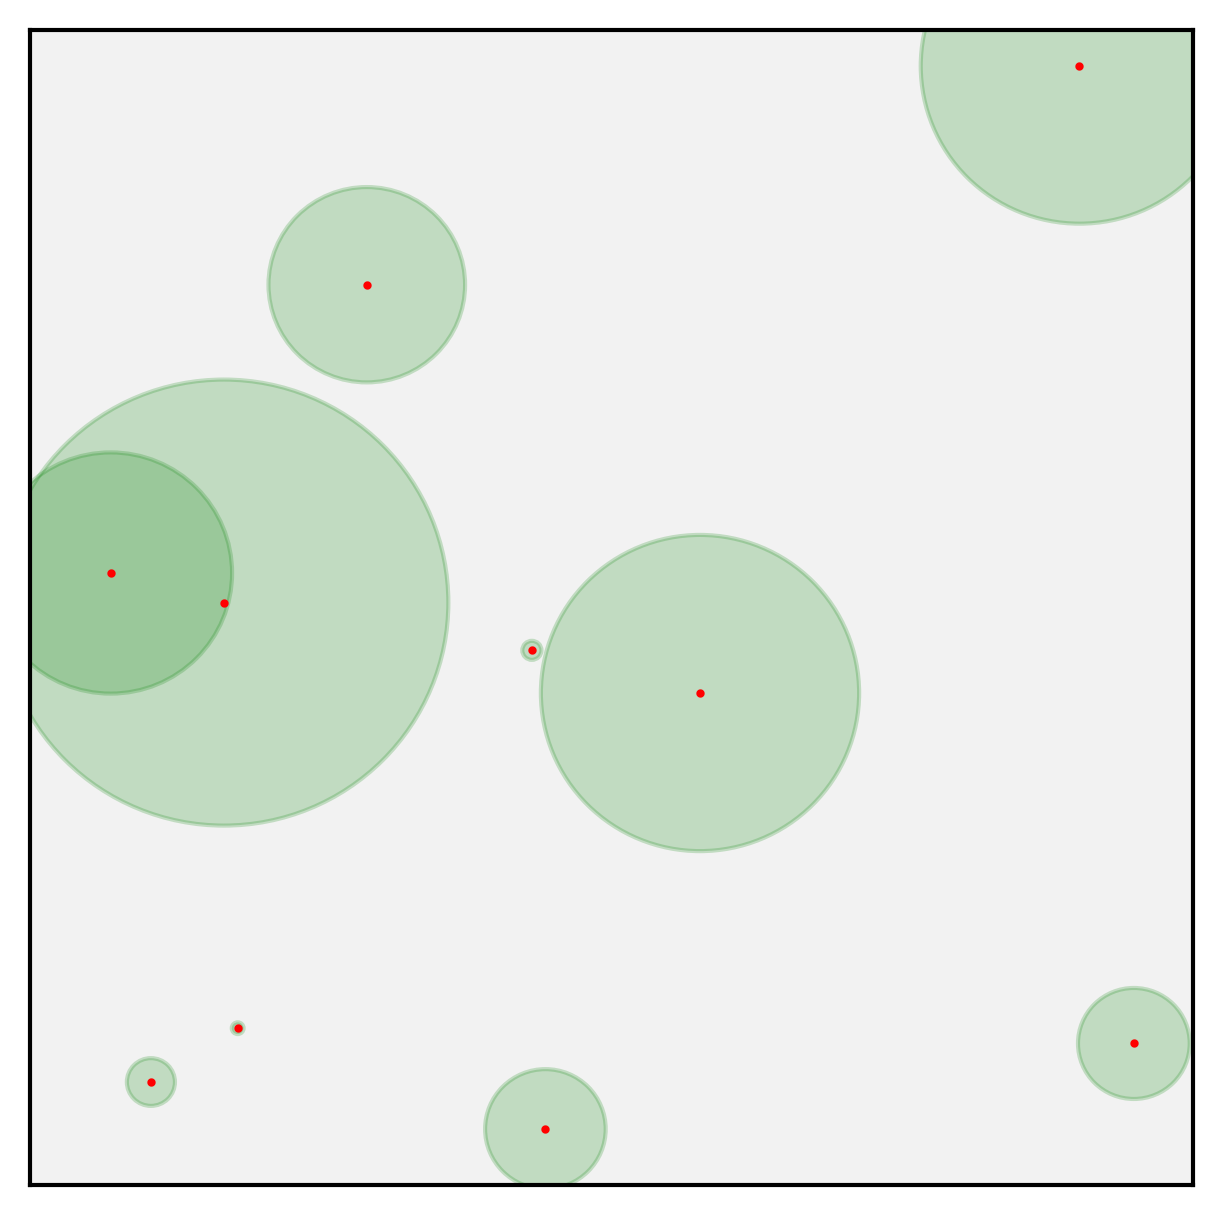

In [6]:
fig = plt.figure()
drawField(sensors)
plt.show()

A more traditional grid would be:

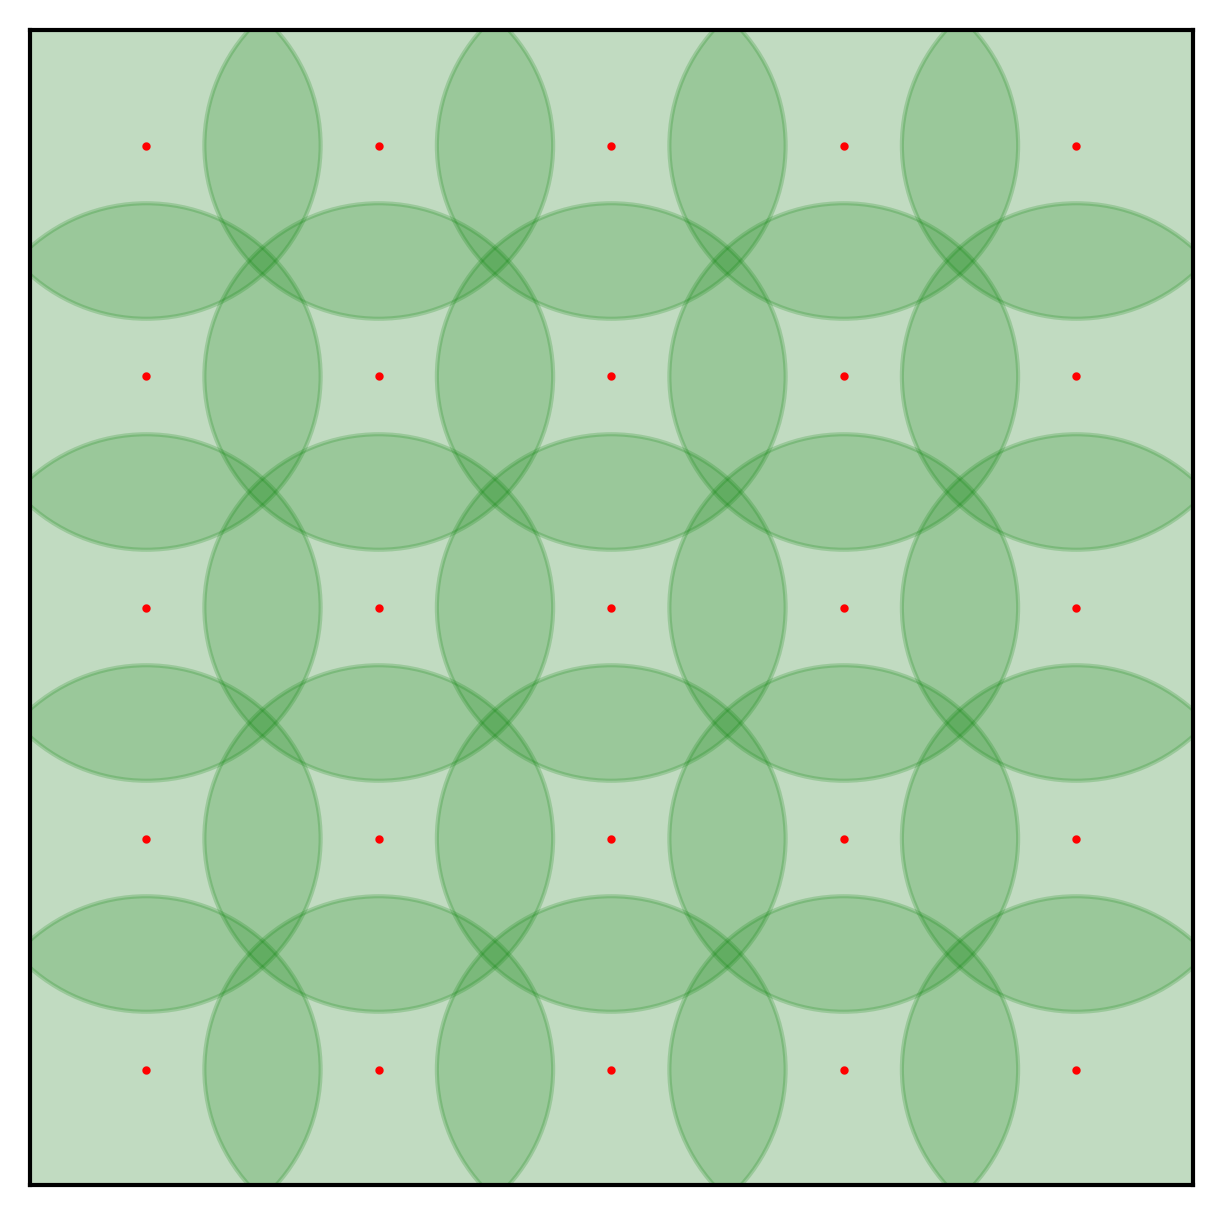

In [7]:
grid = []
d = 0.15
for i in range(5):
    for j in range(5):
        p = [0.1 + (1 / 5) * i, 0.1 + (1 / 5) * j]
        grid.append(SimpleSensor(p, d))

fig = plt.figure()
drawField(grid)
plt.show()

These sensing radii have been crafted to leave no uncovered space, but this means there are several places at which there is considerable overlap which moght result in double-counting if a target happened to be there. We can illustrate this by adding two targets, one in an area observed by only one sensor and one in an area surveilled by four:

Counting 5 targets


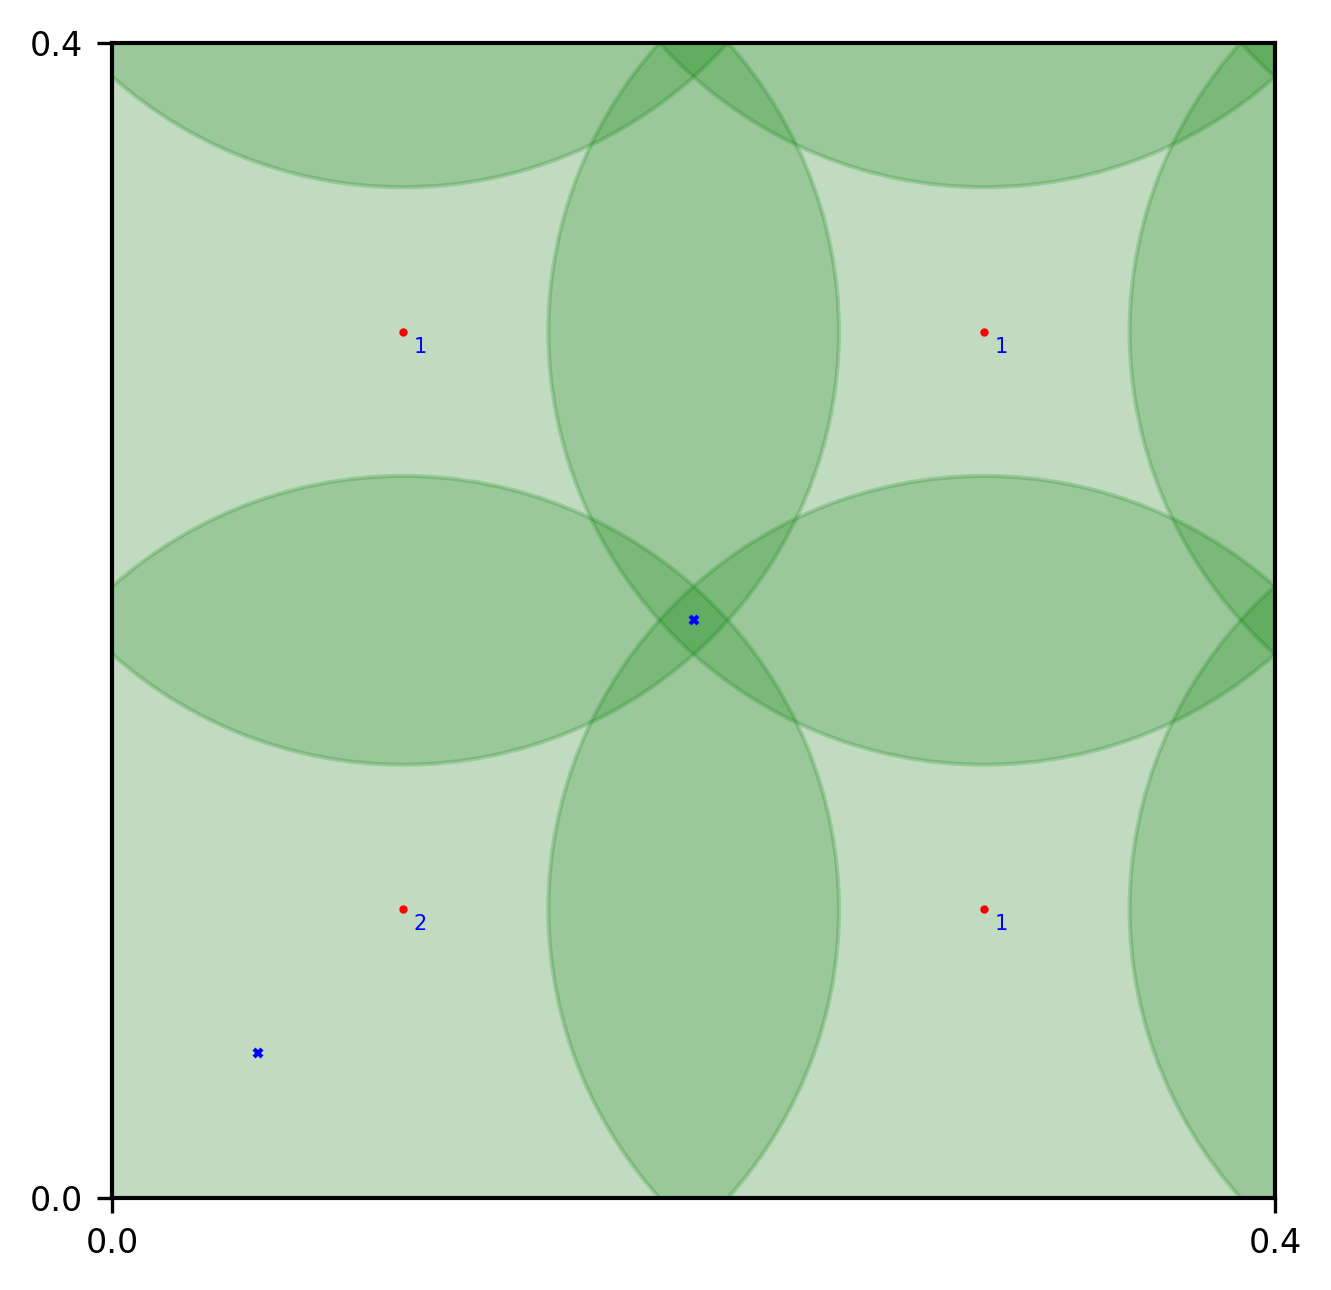

In [15]:
t1 = numpy.array([0.05, 0.05])
t2 = numpy.array([0.2, 0.2])

# count the targets by asking all sensors for their count
targets = 0
for s in grid:
    targets += s.counts([t1, t2])

print(f'Counting {targets} targets')

fig = plt.figure()
drawField(grid, ts=[t1, t2], subfieldWH=(0.4, 0.4), showCount=True)
plt.show()

The essential problem of target counting is to come up with an estimate of the actual number of targets from this raw count, by using information about the sensor's overlapping observations.